In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuração visual
sns.set_theme(style="whitegrid")
%matplotlib inline

In [68]:
# 1. PROCESSAR CHAMADA MANUAL
df_manual = pd.read_csv('Chamada_Manual.csv')

def converter_tempo(t):
    try:
        if isinstance(t, str):
            parts = t.split(':')
            return int(parts[0]) + int(parts[1])/60
        return 0
    except:
        return 0

df_manual['Tempo_Base'] = df_manual['Tempo'].apply(converter_tempo)

# Penalidade
palavras_negativas = ['erro', 'conversa', 'parou', 'reiniciou', 'atrasado', 'imprevisto', 'pediu']
def aplicar_penalidade(row):
    obs = str(row['Observações / Imprevistos']).lower()
    tempo = row['Tempo_Base']
    for palavra in palavras_negativas:
        if palavra in obs:
            return tempo + (5/60)
    return tempo

df_manual['Duracao_Final'] = df_manual.apply(aplicar_penalidade, axis=1)

# Agrupando por Disciplina E Local
manual_resumo = df_manual.groupby(['Disciplina', 'Local'])['Duracao_Final'].mean().reset_index()
manual_resumo.columns = ['Disciplina', 'Ambiente', 'Duracao_Minutos']
manual_resumo['Metodo'] = 'Manual'

# Padronizar nomes dos ambientes
manual_resumo['Ambiente'] = manual_resumo['Ambiente'].str.title().str.strip()


# 2. PROCESSAR SMART ATTENDANCE
df_auto = pd.read_csv('Chamada_Automatizada.csv')
df_auto['Timestamp'] = pd.to_datetime(df_auto['Timestamp Completo'], dayfirst=True)
df_auto['Data'] = df_auto['Timestamp'].dt.date

def calcular_tempo_sessao_inteligente(times):
    times = sorted(times)
    inicio = times[0]
    fim_real = times[0]
    for i in range(1, len(times)):
        diff = (times[i] - times[i-1]).total_seconds() / 60
        if diff > 3: break
        fim_real = times[i]
    duracao = (fim_real - inicio).total_seconds() / 60
    return max(duracao, 0.5)

auto_resumo = df_auto.groupby(['Matéria', 'Tipo de Local', 'Data'])['Timestamp'].apply(calcular_tempo_sessao_inteligente).reset_index(name='Duracao_Minutos')

# Média final por Matéria e Local
auto_resumo = auto_resumo.groupby(['Matéria', 'Tipo de Local'])['Duracao_Minutos'].mean().reset_index()
auto_resumo.columns = ['Disciplina', 'Ambiente', 'Duracao_Minutos']
auto_resumo['Metodo'] = 'Smart Attendance'

# Padronizar nomes
auto_resumo['Ambiente'] = auto_resumo['Ambiente'].str.title().str.strip()


# 3. UNIFICAR
df_final = pd.concat([manual_resumo, auto_resumo])

print("Dados processados com distinção de Ambiente (Lab vs Sala)!")
display(df_final.head())

Dados processados com distinção de Ambiente (Lab vs Sala)!


,Disciplina,Ambiente,Duracao_Minutos,Metodo
0,GPTI,Sala De Aula,4.860417,Manual
1,IA,Laboratório,5.188095,Manual
2,IA,Sala De Aula,5.783333,Manual
3,IHC,Laboratório,4.790000,Manual
4,PI1,Laboratório,4.030556,Manual


In [69]:
media_manual = df_final[df_final['Metodo']=='Manual']['Duracao_Minutos'].mean()
media_auto = df_final[df_final['Metodo']=='Smart Attendance']['Duracao_Minutos'].mean()
economiza = 100 - (media_auto / media_manual * 100)

print("="*40)
print(f"        ANÁLISE DE PERFORMANCE")
print("="*40)
print(f"Tempo Médio Manual...........: {media_manual:.2f} min")
print(f"Tempo Médio Smart Attendance.: {media_auto:.2f} min")
print("-" * 40)
print(f"ECONOMIA REAL................: {economiza:.1f}%")
print("="*40)

        ANÁLISE DE PERFORMANCE
Tempo Médio Manual...........: 4.73 min
Tempo Médio Smart Attendance.: 2.51 min
----------------------------------------
ECONOMIA REAL................: 47.0%


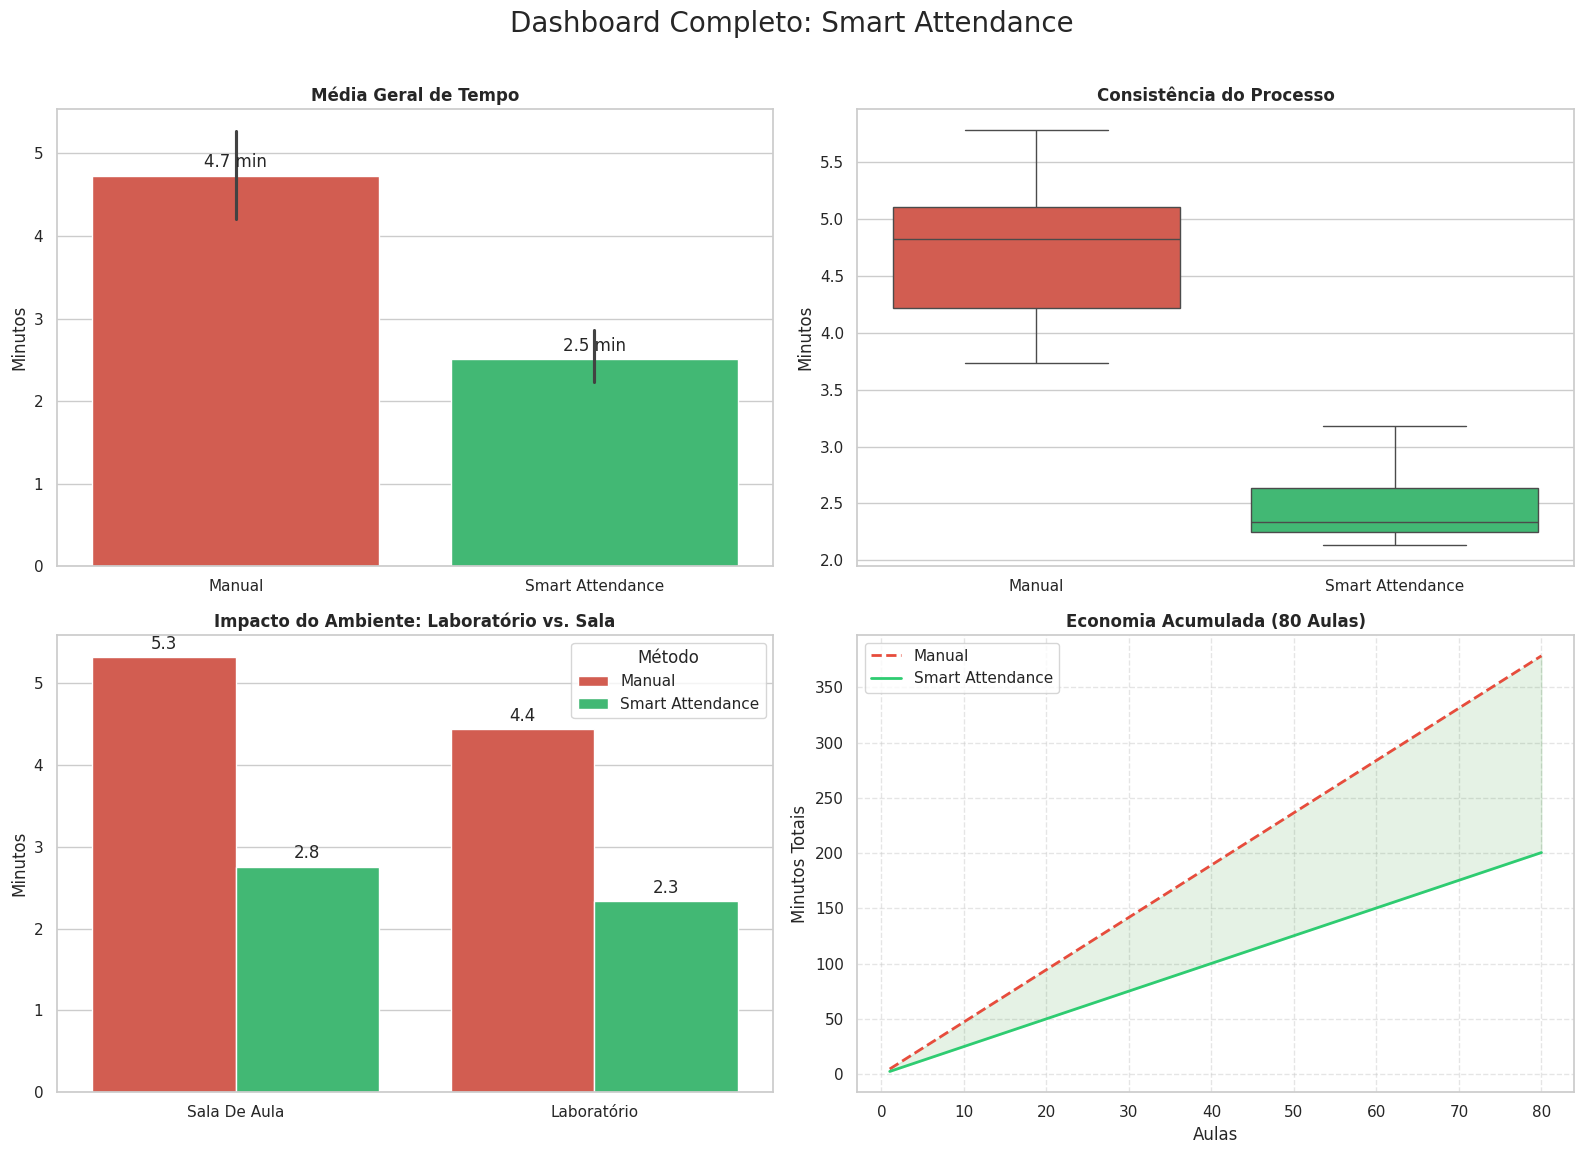

In [70]:
plt.figure(figsize=(16, 12)) # Aumentei um pouco a altura

# --- GRÁFICO 1: Média Geral ---
plt.subplot(2, 2, 1)
ax1 = sns.barplot(data=df_final, x='Metodo', y='Duracao_Minutos', hue='Metodo', palette=['#e74c3c', '#2ecc71'], legend=False)
plt.title('Média Geral de Tempo', fontsize=12, fontweight='bold')
plt.ylabel('Minutos')
plt.xlabel('')
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f min', padding=3)

# --- GRÁFICO 2: Estabilidade ---
plt.subplot(2, 2, 2)
sns.boxplot(data=df_final, x='Metodo', y='Duracao_Minutos', hue='Metodo', palette=['#e74c3c', '#2ecc71'], legend=False)
plt.title('Consistência do Processo', fontsize=12, fontweight='bold')
plt.ylabel('Minutos')
plt.xlabel('')

# --- GRÁFICO 3 (NOVO): Lab vs Sala de Aula ---
plt.subplot(2, 2, 3)
ax3 = sns.barplot(data=df_final, x='Ambiente', y='Duracao_Minutos', hue='Metodo', palette=['#e74c3c', '#2ecc71'], errorbar=None)
plt.title('Impacto do Ambiente: Laboratório vs. Sala', fontsize=12, fontweight='bold')
plt.ylabel('Minutos')
plt.xlabel('')
plt.legend(title='Método')
# Rótulos nas barras
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.1f', padding=3)

# --- GRÁFICO 4: Projeção Semestral ---
plt.subplot(2, 2, 4)
# Recalculando médias para projeção
media_m = df_final[df_final['Metodo'].str.contains('Manual')]['Duracao_Minutos'].mean()
media_a = df_final[df_final['Metodo']=='Smart Attendance']['Duracao_Minutos'].mean()
aulas = np.arange(1, 81)

plt.plot(aulas, np.cumsum([media_m]*80), label='Manual', color='#e74c3c', linewidth=2, linestyle='--')
plt.plot(aulas, np.cumsum([media_a]*80), label='Smart Attendance', color='#2ecc71', linewidth=2)
plt.fill_between(aulas, np.cumsum([media_a]*80), np.cumsum([media_m]*80), color='green', alpha=0.1)

plt.title('Economia Acumulada (80 Aulas)', fontsize=12, fontweight='bold')
plt.xlabel('Aulas')
plt.ylabel('Minutos Totais')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Dashboard Completo: Smart Attendance', fontsize=20, y=0.96)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Dashboard_Final_Completo.png', dpi=300)
plt.show()